In [7]:
import sys
sys.path.append("./utils")
sys.path.append("./model")
from utils import helper
import model_utils
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchvision import datasets
import models
import loss_module

helper.set_random_seed()
batch_size = 128 # batch_size = 128 for arXiv:1512.03385

#get STL10 dataset
unlabeled_dataset = datasets.STL10(root="./stl10_data", split="unlabeled",download=True)
_train_dataset = datasets.STL10(root="./stl10_data", split="train",download=True)
test_dataset = datasets.STL10(root="./stl10_data", split="test",download=True)
_train_dataset,_val_dataset = torch.utils.data.random_split(_train_dataset,[0.9,0.1])


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: title={'center': 'monkey'}>,
         <Axes: title={'center': 'monkey'}>,
         <Axes: title={'center': 'dog'}>,
         <Axes: title={'center': 'bird'}>],
        [<Axes: title={'center': 'car'}>,
         <Axes: title={'center': 'horse'}>,
         <Axes: title={'center': 'deer'}>,
         <Axes: title={'center': 'bird'}>],
        [<Axes: title={'center': 'airplane'}>,
         <Axes: title={'center': 'bird'}>,
         <Axes: title={'center': 'ship'}>,
         <Axes: title={'center': 'cat'}>],
        [<Axes: title={'center': 'airplane'}>,
         <Axes: title={'center': 'dog'}>,
         <Axes: title={'center': 'deer'}>,
         <Axes: title={'center': 'dog'}>]], dtype=object))

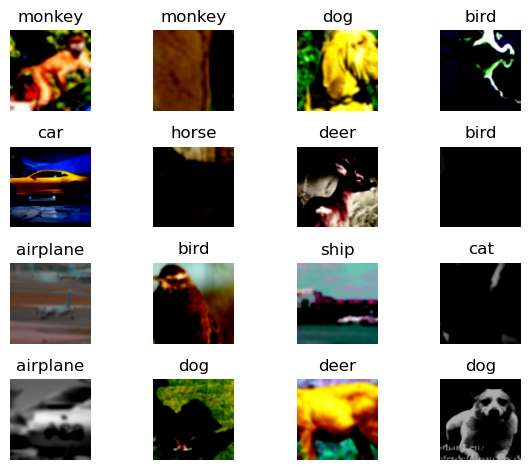

In [4]:
#transfomation
#in https://arxiv.org/pdf/2002.05709
aug_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop(size=(96,96)), # scale=(0.08,1.0),ratio=(0.75,1.33)
                                     transforms.RandomApply( 
                                        [transforms.ColorJitter(brightness=0.8,
                                                            contrast=0.8,
                                                            saturation=0.8,
                                                            hue=0.2)],p=0.8),
                                     transforms.RandomGrayscale(p=0.2),   
                                     transforms.GaussianBlur(kernel_size=9), # kernel_size = 10%*image_size
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


train_dataset = helper.WrappedDataset(_train_dataset,aug_transforms,n_views = 2)
val_dataset = helper.WrappedDataset(_val_dataset,norm_transform)
test_dataset = helper.WrappedDataset(test_dataset,norm_transform)

train_loader = data.DataLoader(train_dataset,batch_size = batch_size,shuffle=True)
val_loader = data.DataLoader(val_dataset,batch_size = batch_size,shuffle=True)
test_loader = data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True)

# show the images after augumentaion
classes = helper.get_stl10_classes()
imgs,labels = next(iter(train_loader))

img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(batch_size):
        img_list.append(imgs[i_view][j_img])
        #label_list.append("unlabeled")
        label_list.append(classes[labels[i_view][j_img]])
helper.show_images(img_list,4,4,label_list)
                                

In [8]:
# get the model
net = models.SimpleCLRNet(embedded_dim=128,resnet_type="resnet18")
# define the loss function
info_nce_loss_fn = loss_module.InfoNCELoss(n_views=2,batch_size=batch_size,tau=0.1)
# define the optimizer 
sgd_optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9,weight_decay=0.0001)
# get the device
device = helper.get_device()

contrastive_trainer = model_utils.model_trainer(net = net,optimizer = sgd_optimizer,scheduler = None,loss = info_nce_loss_fn,
                train_loader = unlabeled_dataset,test_loader = None,val_loader = None,
                logdir = "./simpleCLR_runs",n_rec_loss = 1,n_rec_weight = 50,
                device = device)

contrastive_trainer.train_model(n_epoch = 10)




In [4]:
# in the paper it is trained for around 160 epoches
with helper.Timer("Training"):
    accs = model_utils.train_model(net,sgd_optimizer,loss_fn,train_loader,test_loader,val_loader,
                n_epoch=50, n_converge = 10,device = device)
    torch.cuda.synchronize(device)

epoch=0,training accuracy is 0.286

epoch=1,training accuracy is 0.435

epoch=2,training accuracy is 0.514

epoch=3,training accuracy is 0.577

epoch=4,training accuracy is 0.622

epoch=5,training accuracy is 0.659

Training took 103.44820499420166 sec


KeyboardInterrupt: 

In [5]:
print(accs)

{'training_accs': [0.27416667342185974, 0.43058890104293823, 0.5180888772010803, 0.5839444398880005, 0.6358555555343628, 0.667033314704895, 0.6897000074386597, 0.7135444283485413, 0.7309666872024536, 0.7442777752876282, 0.7590555548667908, 0.7668111324310303, 0.7710666656494141, 0.7823889255523682, 0.7927666902542114, 0.7976444363594055, 0.8050000071525574, 0.8103222250938416, 0.814466655254364, 0.8213000297546387, 0.8250333666801453, 0.8271222114562988, 0.8339222073554993, 0.8374555706977844, 0.8391777873039246, 0.8422889113426208, 0.8482999801635742, 0.849922239780426, 0.8523111343383789, 0.8554666638374329, 0.8567000031471252, 0.8599889278411865, 0.8628333210945129, 0.8625444769859314, 0.8668110966682434, 0.8696222305297852, 0.8715111017227173, 0.8732666969299316, 0.8737666606903076, 0.875677764415741, 0.8778889179229736, 0.8790667057037354, 0.8797555565834045, 0.8811777830123901, 0.8822555541992188, 0.88227778673172, 0.8854889273643494, 0.8877222537994385, 0.8869333267211914, 0.889

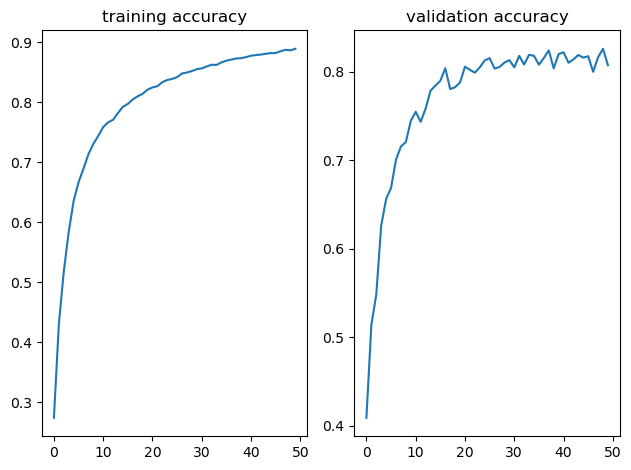

In [6]:
fig,axes = plt.subplots(1,2)
axes[0].set_title("training accuracy")
axes[0].plot(accs["training_accs"])
axes[1].set_title("validation accuracy")
axes[1].plot(accs["val_accs"])
fig.tight_layout()